In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = './'
train_dir = './train/'
test_dir = './test/'

classes = ['active', 'passive', 'chill']

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    src_dir = os.path.join(data_dir, class_name)
    images = os.listdir(src_dir)

    train, val = train_test_split(images, test_size=0.2, random_state=42)

    for image in train:
        src_path = os.path.join(src_dir, image)
        dst_path = os.path.join(train_dir, class_name, image)
        shutil.copyfile(src_path, dst_path)

    for image in val:
        src_path = os.path.join(src_dir, image)
        dst_path = os.path.join(test_dir, class_name, image)
        shutil.copyfile(src_path, dst_path)


train_count = 0
test_count = 0

for root, dirs, files in os.walk(train_dir):
    train_count += len(files)

for root, dirs, files in os.walk(test_dir):
    test_count += len(files)

print(f"Количество файлов:")
print(f"- Train: {train_count}")
print(f"- Validation: {test_count}")

Количество файлов:
- Train: 1310
- Validation: 329


In [12]:
import cv2
class0Im = os.path.join(os.getcwd(), data_dir, train_dir, train_dir+'/active')
class1Im = os.path.join(os.getcwd(), data_dir, train_dir, train_dir+'/passive')
class2Im = os.path.join(os.getcwd(), data_dir, train_dir, train_dir+'/chill')

class0ImTest = os.path.join(os.getcwd(), data_dir, train_dir, test_dir+'/active')
class1ImTest = os.path.join(os.getcwd(), data_dir, train_dir, test_dir+'/passive')
class2ImTest = os.path.join(os.getcwd(), data_dir, train_dir, test_dir+'/chill')

class0Data = sorted([os.path.join(class0Im, f) for f in os.listdir(class0Im)])
class1Data = sorted([os.path.join(class1Im, f) for f in os.listdir(class1Im)])
class2Data = sorted([os.path.join(class2Im, f) for f in os.listdir(class2Im)])

class0DataTest = sorted([os.path.join(class0ImTest, f) for f in os.listdir(class0ImTest)])
class1DataTest = sorted([os.path.join(class1ImTest, f) for f in os.listdir(class1ImTest)])
class2DataTest = sorted([os.path.join(class2ImTest, f) for f in os.listdir(class2ImTest)])

images_filepaths = [*class0Data, *class1Data, *class2Data]
test_images_dilepaths = [*class0DataTest, *class1DataTest, *class2DataTest]

correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] # получаем список корректных путей файлов, которые составляют обучающий набор
correct_testimages_filepaths = [i for i in test_images_dilepaths if cv2.imread(i) is not None]

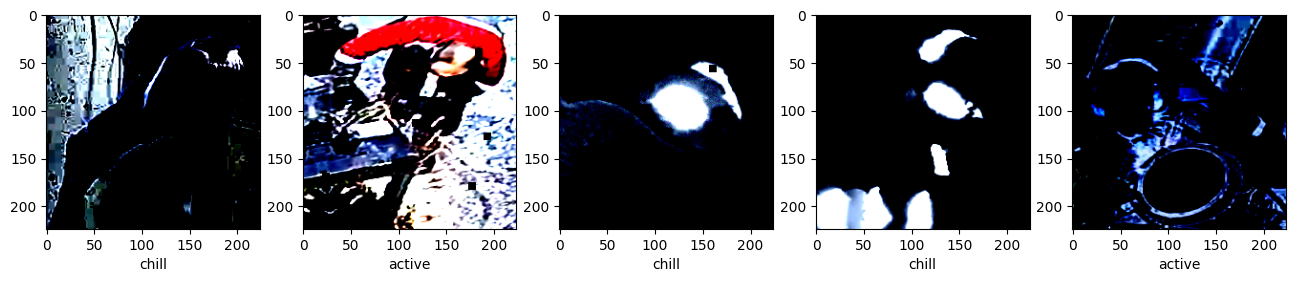

In [22]:
import torch
import torchvision.transforms.functional as F
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
# from google.colab.patches import cv2_imshow
import torchvision
import matplotlib.pyplot as plt
import numpy as np

class AlbumentationsTransform:
    def __init__(self, transforms):
        self.transforms = A.Compose(transforms)

    def __call__(self, img):
        img = np.array(img)
        img = self.transforms(image=img)["image"]
#         img = torchvision.transforms.ToTensor()(img)
        return img


class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        img = self.transforms(img)
        return img

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, p=0.5),
    A.Blur(blur_limit=1, p=0.1),
    A.GaussNoise(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.22)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.22)),
    ToTensorV2()
])

train_data = torchvision.datasets.ImageFolder(
    os.path.join(os.getcwd(), data_dir, train_dir),
    transform=Transforms(AlbumentationsTransform(train_transform)),
)

test_data = torchvision.datasets.ImageFolder(
    os.path.join(os.getcwd(), data_dir, test_dir),
    transform=Transforms(AlbumentationsTransform(test_transform)),
)

# Закидываем в даталоадер
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False) # для тестовой выборки не обязательно перемешивать

# imageFolder автоматом определяет название классов по названию папок:
class_names = train_data.classes


data, labels = next(iter(train_loader))
data, labels = data[0:5], labels[0:5]

# Отображаем на графике
fig = plt.figure(figsize=(16, 9))
for i in range(0, 5):
    fig.add_subplot(1, 5, i + 1)
    plt.imshow(data[i].permute(1, 2, 0))
    plt.xlabel(class_names[labels[i]])

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Создание модели ResNet50
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet50 = model_resnet50.to(device)

# Определение функции потерь и оптимизатора
criterion_resnet50 = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.001)

# Обучение ResNet50
num_epochs = 30
for epoch in range(num_epochs):
    model_resnet50.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Очищаем предыдущие предсказания и метки
    all_predictions = []
    all_labels = []

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer_resnet50.zero_grad()
        outputs = model_resnet50(data)
        loss = criterion_resnet50(outputs, labels)
        loss.backward()
        optimizer_resnet50.step()

        # Считаем статистику для вывода
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Добавляем текущие предсказания и метки в списки
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Выводим метрики после каждой эпохи
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100.0
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s] 


Epoch [1/30], Loss: 0.8624, Accuracy: 61.83%, Precision: 0.6165, Recall: 0.6183, F1: 0.6125
Epoch [2/30], Loss: 0.6584, Accuracy: 72.75%, Precision: 0.7282, Recall: 0.7275, F1: 0.7268
Epoch [3/30], Loss: 0.5528, Accuracy: 78.32%, Precision: 0.7820, Recall: 0.7832, F1: 0.7819
Epoch [4/30], Loss: 0.5205, Accuracy: 79.47%, Precision: 0.7946, Recall: 0.7947, F1: 0.7935
Epoch [5/30], Loss: 0.5073, Accuracy: 80.23%, Precision: 0.8031, Recall: 0.8023, F1: 0.8022
Epoch [6/30], Loss: 0.4299, Accuracy: 83.82%, Precision: 0.8375, Recall: 0.8382, F1: 0.8375
Epoch [7/30], Loss: 0.3962, Accuracy: 83.82%, Precision: 0.8383, Recall: 0.8382, F1: 0.8381
Epoch [8/30], Loss: 0.4068, Accuracy: 83.51%, Precision: 0.8359, Recall: 0.8351, F1: 0.8349
Epoch [9/30], Loss: 0.3448, Accuracy: 86.72%, Precision: 0.8679, Recall: 0.8672, F1: 0.8674
Epoch [10/30], Loss: 0.3697, Accuracy: 85.88%, Precision: 0.8580, Recall: 0.8588, F1: 0.8583
Epoch [11/30], Loss: 0.3511, Accuracy: 87.56%, Precision: 0.8758, Recall: 0.875

In [24]:
# Создание модели ResNet101
model_resnet101 = models.resnet101(pretrained=True)
num_ftrs = model_resnet101.fc.in_features
model_resnet101.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet101 = model_resnet101.to(device)

# Определение функции потерь и оптимизатора
criterion_resnet101 = nn.CrossEntropyLoss()
optimizer_resnet101 = optim.Adam(model_resnet101.parameters(), lr=0.001)

# Обучение ResNet101
for epoch in range(num_epochs):
    model_resnet101.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer_resnet101.zero_grad()
        outputs = model_resnet101(data)
        loss = criterion_resnet101(outputs, labels)
        loss.backward()
        optimizer_resnet101.step()

        # Считаем статистику для вывода
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Сохраняем предсказания и метки для вычисления метрик
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Вычисляем precision, recall и F-меру
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Выводим метрики после каждой эпохи
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100.0
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.9769, Accuracy: 55.50%, Precision: 0.5171, Recall: 0.5550, F1: 0.5251
Epoch [2/30], Loss: 0.7609, Accuracy: 65.42%, Precision: 0.6476, Recall: 0.6542, F1: 0.6421
Epoch [3/30], Loss: 0.6013, Accuracy: 74.58%, Precision: 0.7463, Recall: 0.7458, F1: 0.7450
Epoch [4/30], Loss: 0.5085, Accuracy: 79.47%, Precision: 0.7957, Recall: 0.7947, F1: 0.7950
Epoch [5/30], Loss: 0.4732, Accuracy: 80.92%, Precision: 0.8093, Recall: 0.8092, F1: 0.8086
Epoch [6/30], Loss: 0.3941, Accuracy: 85.50%, Precision: 0.8550, Recall: 0.8550, F1: 0.8549
Epoch [7/30], Loss: 0.4233, Accuracy: 82.67%, Precision: 0.8256, Recall: 0.8267, F1: 0.8259
Epoch [8/30], Loss: 0.3705, Accuracy: 85.42%, Precision: 0.8541, Recall: 0.8542, F1: 0.8541
Epoch [9/30], Loss: 0.3952, Accuracy: 85.27%, Precision: 0.8530, Recall: 0.8527, F1: 0.8526
Epoch [10/30], Loss: 0.3782, Accuracy: 85.19%, Precision: 0.8522, Recall: 0.8519, F1: 0.8520
Epoch [11/30], Loss: 0.3539, Accuracy: 86.26%, Precision: 0.8625, Recall: 0.862

In [8]:
# Создание модели ResNet152
model_resnet152 = models.resnet152(pretrained=True)
num_ftrs = model_resnet152.fc.in_features
model_resnet152.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet152 = model_resnet152.to(device)

# Определение функции потерь и оптимизатора
criterion_resnet152 = nn.CrossEntropyLoss()
optimizer_resnet152 = optim.Adam(model_resnet152.parameters(), lr=0.001)

# Обучение ResNet152
for epoch in range(num_epochs):
    model_resnet152.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer_resnet152.zero_grad()
        outputs = model_resnet152(data)
        loss = criterion_resnet152(outputs, labels)
        loss.backward()
        optimizer_resnet152.step()

        # Считаем статистику для вывода
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Сохраняем предсказания и метки для вычисления метрик
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Вычисляем precision, recall и F-меру
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Выводим метрики после каждой эпохи
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100.0
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 64.2MB/s] 


Epoch [1/30], Loss: 0.8366, Accuracy: 64.96%, Precision: 0.6490, Recall: 0.6496, F1: 0.6454
Epoch [2/30], Loss: 0.6215, Accuracy: 74.73%, Precision: 0.7478, Recall: 0.7473, F1: 0.7463
Epoch [3/30], Loss: 0.5351, Accuracy: 78.32%, Precision: 0.7836, Recall: 0.7832, F1: 0.7827
Epoch [4/30], Loss: 0.4763, Accuracy: 81.07%, Precision: 0.8103, Recall: 0.8107, F1: 0.8099
Epoch [5/30], Loss: 0.4609, Accuracy: 81.45%, Precision: 0.8134, Recall: 0.8145, F1: 0.8135
Epoch [6/30], Loss: 0.4237, Accuracy: 82.67%, Precision: 0.8268, Recall: 0.8267, F1: 0.8266
Epoch [7/30], Loss: 0.3969, Accuracy: 85.04%, Precision: 0.8500, Recall: 0.8504, F1: 0.8494
Epoch [8/30], Loss: 0.3986, Accuracy: 84.89%, Precision: 0.8502, Recall: 0.8489, F1: 0.8491
Epoch [9/30], Loss: 0.3399, Accuracy: 87.18%, Precision: 0.8717, Recall: 0.8718, F1: 0.8716
Epoch [10/30], Loss: 0.3443, Accuracy: 87.40%, Precision: 0.8734, Recall: 0.8740, F1: 0.8735
Epoch [11/30], Loss: 0.3276, Accuracy: 87.48%, Precision: 0.8749, Recall: 0.874

In [17]:
!pip install torchsummary

In [18]:
from torchsummary import summary

In [20]:
summary(model_resnet101, input_size = (3, 224, 224), batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           9,408
       BatchNorm2d-2          [1, 64, 112, 112]             128
              ReLU-3          [1, 64, 112, 112]               0
         MaxPool2d-4            [1, 64, 56, 56]               0
            Conv2d-5            [1, 64, 56, 56]           4,096
       BatchNorm2d-6            [1, 64, 56, 56]             128
              ReLU-7            [1, 64, 56, 56]               0
            Conv2d-8            [1, 64, 56, 56]          36,864
       BatchNorm2d-9            [1, 64, 56, 56]             128
             ReLU-10            [1, 64, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]          16,384
      BatchNorm2d-12           [1, 256, 56, 56]             512
           Conv2d-13           [1, 256, 56, 56]          16,384
      BatchNorm2d-14           [1, 256,

In [25]:
# Сохранение модели
torch.save(model_resnet101.state_dict(), 'resnet101_model.pth')

# # Сохранение оптимизатора (если нужно)
# torch.save(optimizer_resnet50.state_dict(), 'resnet50_optimizer.pth')